In [2]:
import logging
import pickle
import random
from contextlib import contextmanager
from functools import partial
from typing import Callable

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from lightning.pytorch.utilities import disable_possible_user_warnings

from probcal.data_modules import TabularDataModuleWithIndices
from probcal.enums import LRSchedulerType, OptimizerType
from probcal.evaluation.kernels import rbf_kernel
from probcal.evaluation.metrics import compute_mcmd_torch
from probcal.models import GaussianNN
from probcal.models.probabilistic_regression_nn import ProbabilisticRegressionNN
from probcal.models.backbones import MLP

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)

/Users/stocktonjenkins/src/uw/cce-active-learning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'LRScheduler' from 'torch.optim.lr_scheduler' (/Users/stocktonjenkins/src/uw/cce-active-learning/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py)

In [257]:
@contextmanager
def seed_context(seed):
    torch_state = torch.get_rng_state()
    cuda_state = torch.cuda.get_rng_state_all()
    numpy_state = np.random.get_state()
    random_state = random.getstate()
    
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        yield
    finally:
        torch.set_rng_state(torch_state)
        torch.cuda.set_rng_state_all(cuda_state)
        np.random.set_state(numpy_state)
        random.setstate(random_state)

In [258]:
raw_data = np.load("data/discrete_sine_wave/discrete_sine_wave.npz")
X_train_full = torch.tensor(raw_data["X_train"]).float()
y_train_full = torch.tensor(raw_data["y_train"]).float()
X_val = torch.tensor(raw_data["X_val"]).float()
y_val = torch.tensor(raw_data["y_val"]).float()
X_test = torch.tensor(raw_data["X_test"]).float()
y_test = torch.tensor(raw_data["y_test"]).float()

x_kernel = partial(rbf_kernel, gamma=1/(2*torch.var(X_val)))
y_kernel = partial(rbf_kernel, gamma=1/(2*torch.var(y_val)))

In [259]:
def run_active_learning(
    init_train_indices: np.ndarray,
    num_to_add: int,
    num_stages: int,
    fixed_seed: int,
    strategy: Callable[
        [ProbabilisticRegressionNN, np.ndarray, int],
        np.ndarray,
    ],
):
    epochs = 100
    mae_vals = []
    nll_vals = []
    mcmd_vals = []
    y_hat_vals = []
    selected_indices = []

    train_indices = init_train_indices.copy()

    for _ in tqdm(range(num_stages)):

        selected_indices.append(train_indices)
        
        with seed_context(fixed_seed):
            model = GaussianNN(
                backbone_type=MLP,
                backbone_kwargs={"input_dim": 1},
                optim_type=OptimizerType.ADAM_W,
                optim_kwargs={"lr": 0.001, "weight_decay": 0.00001},
                lr_scheduler_type=LRSchedulerType.COSINE_ANNEALING,
                lr_scheduler_kwargs={"T_max": epochs, "eta_min": 0, "last_epoch": -1},
            )
            datamodule = TabularDataModuleWithIndices(
                dataset_path="data/discrete_sine_wave/discrete_sine_wave.npz",
                batch_size=8,
                train_indices=train_indices,
                num_workers=0,
                persistent_workers=False,
            )
            trainer = L.Trainer(
                accelerator="cpu",
                max_epochs=epochs,
                min_epochs=epochs,
                logger=False,
                enable_model_summary=False,
                enable_progress_bar=False,
                enable_checkpointing=False,
            )
            trainer.fit(model, datamodule)
            metrics = trainer.test(model, datamodule, verbose=False)[0]
        mae, nll = metrics["test_mae"], metrics["nll"]

        with torch.inference_mode():
            num_mcmd_samples = 3
            y_hat_test = model.predict(X_test.view(-1, 1))
            y_prime = model.sample(y_hat_test, num_samples=num_mcmd_samples).flatten()
            mcmd = compute_mcmd_torch(
                grid=X_test,
                x=X_test,
                y=y_test,
                x_prime=torch.repeat_interleave(X_test, repeats=num_mcmd_samples),
                y_prime=y_prime,
                x_kernel=x_kernel,
                y_kernel=y_kernel,
                lmbda=0.1,
            ).mean().item()
        mae_vals.append(mae)
        nll_vals.append(nll)
        mcmd_vals.append(mcmd)
        y_hat_vals.append(y_hat_test)

        candidate_indices = np.where(~np.isin(np.arange(len(X_train_full)), train_indices))[0]
        new_train_indices = strategy(model, candidate_indices, num_to_add)
        train_indices = np.concatenate([train_indices, new_train_indices])
    
    return {
        "mae": mae_vals,
        "nll": nll_vals,
        "mcmd": mcmd_vals,
        "y_hat": y_hat_vals,
        "indices": selected_indices,
    }

In [260]:
def random_strategy(model: ProbabilisticRegressionNN, candidate_indices: np.ndarray, num_to_add: int):
    return np.random.choice(candidate_indices, size=num_to_add, replace=False)

def greedy_mcmd_strategy(model: ProbabilisticRegressionNN, candidate_indices: np.ndarray, num_to_add: int, epsilon: float = 0.15):
    new_train_indices = []
    candidate_indices_copy = candidate_indices.copy()
    with torch.inference_mode():
        y_hat_val = model.predict(X_val.view(-1, 1))
        y_prime = model.sample(y_hat_val, num_samples=3).flatten()
        x_prime = torch.repeat_interleave(X_val, repeats=3)
        mcmd_vals = compute_mcmd_torch(
            grid=X_train_full[candidate_indices_copy],
            x=X_val,
            y=y_val,
            x_prime=x_prime,
            y_prime=y_prime,
            x_kernel=x_kernel,
            y_kernel=y_kernel,
            lmbda=0.1,
        )
    for _ in range(num_to_add):
        if np.random.rand() < epsilon:
            pick_idx = np.random.choice(len(candidate_indices_copy))
        else:
            pick_idx = torch.argmax(mcmd_vals).item()
        new_train_indices.append(candidate_indices_copy[pick_idx])
        candidate_indices_copy = np.delete(candidate_indices_copy, pick_idx) 
        mcmd_vals = np.delete(mcmd_vals, pick_idx)
    return np.array(new_train_indices)

def greedy_var_strategy(model: ProbabilisticRegressionNN, candidate_indices: np.ndarray, num_to_add: int, epsilon: float = 0.15):
    new_train_indices = []
    candidate_indices_copy = candidate_indices.copy()
    with torch.inference_mode():
        vars = model.predict(X_train_full[candidate_indices].view(-1, 1))[:, 1]
        
    for _ in range(num_to_add):
        if np.random.rand() < epsilon:
            pick_idx = np.random.choice(len(candidate_indices_copy))
        else:
            pick_idx = torch.argmax(vars).item()
        new_train_indices.append(candidate_indices_copy[pick_idx])
        candidate_indices_copy = np.delete(candidate_indices_copy, pick_idx) 
        vars = np.delete(vars, pick_idx) 
    return np.array(new_train_indices)

def mcmd_weighted_strategy(model: ProbabilisticRegressionNN, candidate_indices: np.ndarray, num_to_add: int):
    with torch.inference_mode():
        y_hat_val = model.predict(X_val.view(-1, 1))
        y_prime = model.sample(y_hat_val, num_samples=3).flatten()
        x_prime = torch.repeat_interleave(X_val, repeats=3)
        mcmd_vals = compute_mcmd_torch(
            grid=X_train_full[candidate_indices],
            x=X_val,
            y=y_val,
            x_prime=x_prime,
            y_prime=y_prime,
            x_kernel=x_kernel,
            y_kernel=y_kernel,
            lmbda=0.1,
        ).detach().numpy()
    weights = mcmd_vals / mcmd_vals.sum()
    new_train_indices = np.random.choice(candidate_indices, size=num_to_add, replace=False, p=weights) 
    return new_train_indices

def var_weighted_strategy(model: ProbabilisticRegressionNN, candidate_indices: np.ndarray, num_to_add: int):
    with torch.inference_mode():
        vars = model.predict(X_train_full[candidate_indices].view(-1, 1))[:, 1].detach().numpy()
    weights = vars / vars.sum()
    new_train_indices = np.random.choice(candidate_indices, size=num_to_add, replace=False, p=weights) 
    return new_train_indices

def mcmd_softmax_strategy(model: ProbabilisticRegressionNN, candidate_indices: np.ndarray, num_to_add: int, t: float = 1.0):
    with torch.inference_mode():
        y_hat_val = model.predict(X_val.view(-1, 1))
        y_prime = model.sample(y_hat_val, num_samples=3).flatten()
        x_prime = torch.repeat_interleave(X_val, repeats=3)
        mcmd_vals = compute_mcmd_torch(
            grid=X_train_full[candidate_indices],
            x=X_val,
            y=y_val,
            x_prime=x_prime,
            y_prime=y_prime,
            x_kernel=x_kernel,
            y_kernel=y_kernel,
            lmbda=0.1,
        )
    weights = torch.softmax(mcmd_vals / t, dim=-1).detach().numpy()
    weights = weights / weights.sum()
    new_train_indices = np.random.choice(candidate_indices, size=num_to_add, replace=False, p=weights) 
    return new_train_indices

In [ ]:
num_init_train = 50
data_indices = np.arange(len(X_train_full))
np.random.shuffle(data_indices)
init_train_indices = data_indices[:num_init_train]

num_stages = 6
num_to_add = 50

for i in range(5):
    random_results = run_active_learning(
        init_train_indices=init_train_indices,
        num_to_add=num_to_add,
        num_stages=num_stages,
        fixed_seed=1998, 
        strategy=random_strategy,
    )
    with open(f"active-learning-results/random_{i}.pkl", "wb") as f:
        pickle.dump(random_results, f)
    greedy_mcmd_results = run_active_learning(
        init_train_indices=init_train_indices,
        num_to_add=num_to_add,
        num_stages=num_stages,
        fixed_seed=1998, 
        strategy=greedy_mcmd_strategy,
    )
    with open(f"active-learning-results/greedy_mcmd_{i}.pkl", "wb") as f:
        pickle.dump(greedy_mcmd_results, f)
    mcmd_weighted_results = run_active_learning(
        init_train_indices=init_train_indices,
        num_to_add=num_to_add,
        num_stages=num_stages,
        fixed_seed=1998, 
        strategy=mcmd_weighted_strategy,
    )
    with open(f"active-learning-results/mcmd_weighted_{i}.pkl", "wb") as f:
        pickle.dump(mcmd_weighted_results, f)
    greedy_var_results = run_active_learning(
        init_train_indices=init_train_indices,
        num_to_add=num_to_add,
        num_stages=num_stages,
        fixed_seed=1998, 
        strategy=greedy_var_strategy,
    )
    with open(f"active-learning-results/greedy_var_{i}.pkl", "wb") as f:
        pickle.dump(greedy_var_results, f)
    var_weighted_results = run_active_learning(
        init_train_indices=init_train_indices,
        num_to_add=num_to_add,
        num_stages=num_stages,
        fixed_seed=1998, 
        strategy=var_weighted_strategy,
    )
    with open(f"active-learning-results/var_weighted_{i}.pkl", "wb") as f:
        pickle.dump(var_weighted_results, f)
    mcmd_softmax_results = run_active_learning(
        init_train_indices=init_train_indices,
        num_to_add=50,
        num_stages=6,
        fixed_seed=1998,
        strategy=partial(mcmd_softmax_strategy, t=0.1), # TODO: Explore annealing the temperature value.
    )
    with open(f"active-learning-results/mcmd_softmax_{i}.pkl", "wb") as f:
        pickle.dump(mcmd_softmax_results, f)

In [275]:
from typing import Literal
from seaborn import color_palette

def plot_data_selection(
    strategy: Literal["random", "greedy_mcmd", "greedy_var", "mcmd_weighted", "var_weighted"],
    trial: int,
):
    with open(f"active-learning-results/{strategy}_{trial}.pkl", "rb") as f:
        results = pickle.load(f)
    
    num_stages = len(results["indices"])
    fig, axs = plt.subplots(2, num_stages // 2, figsize=(8, 6), sharey="all")

    for i, ax in enumerate(axs.ravel()):
        ax.set_title(f"Stage {i+1}")
        indices = results["indices"][i]
        ax.scatter(X_train_full[indices], y_train_full[indices], alpha=0.2)

        mu, var = torch.split(results["y_hat"][i], [1, 1], dim=-1)
        mu = mu.flatten()
        std = var.sqrt().flatten()

        order = torch.argsort(X_test.flatten())
        lower = (mu - 2*std)[order]
        upper = (mu + 2*std)[order]
        ax.plot(X_test[order].flatten(), mu[order], color="black", alpha=0.5)
        ax.fill_between(X_test[order].flatten(), lower, upper, color="gray", alpha=0.1)
        ax.axis("off")        

        if i < num_stages - 1:
            next_indices = results["indices"][i+1]
            for_next_time = np.setdiff1d(next_indices, indices)
            ax.scatter(X_train_full[for_next_time], y_train_full[for_next_time], alpha=0.8, color="lightgreen")
    
    fig.suptitle(strategy)
    fig.tight_layout()
    plt.show()

def plot_all_metrics(strategies: list[str]):
    fig, axs = plt.subplots(3, 1, figsize=(12, 12))
    colors = color_palette(n_colors=len(strategies))

    axs[0].set_ylabel("mae")
    axs[1].set_ylabel("nll")
    axs[2].set_ylabel("mcmd")
    for strategy, color in zip(strategies, colors):
        for i, metric in enumerate(("mae", "nll", "mcmd")):
            metric_vals = []
            for j in range(5):
                with open(f"active-learning-results/{strategy}_{j}.pkl", "rb") as f:
                    results = pickle.load(f)
                metric_vals.append(results[metric])
            metric_vals = np.stack(metric_vals, axis=0)
            mean_metric = metric_vals.mean(axis=0)
            std_metric = metric_vals.std(axis=0, ddof=1)

            axs[i].plot(mean_metric, color=color, alpha=0.7, label=strategy)
            axs[i].fill_between(np.arange(len(mean_metric)), mean_metric - std_metric, mean_metric + std_metric, alpha=0.3, color=color)

    [ax.legend() for ax in axs.ravel()]
    fig.tight_layout()
    plt.show()

In [244]:
from probcal.training.beta_schedulers import CosineAnnealingBetaScheduler


for i in range(5):
    epochs = 100
    mae_vals = []
    nll_vals = []
    mcmd_vals = []
    y_hat_vals = []
    selected_indices = []

    train_indices = init_train_indices.copy()

    t_scheduler = CosineAnnealingBetaScheduler(beta_0=0.1, beta_1=0.001, last_epoch=num_stages-1)

    for _ in tqdm(range(num_stages)):

        strategy = partial(mcmd_softmax_strategy, t=t_scheduler.current_value)
        t_scheduler.step()

        selected_indices.append(train_indices)
        
        with seed_context(1998):
            model = GaussianNN(
                backbone_type=MLP,
                backbone_kwargs={"input_dim": 1},
                optim_type=OptimizerType.ADAM_W,
                optim_kwargs={"lr": 0.001, "weight_decay": 0.00001},
                lr_scheduler_type=LRSchedulerType.COSINE_ANNEALING,
                lr_scheduler_kwargs={"T_max": epochs, "eta_min": 0, "last_epoch": -1},
            )
            datamodule = TabularDataModuleWithIndices(
                dataset_path="data/discrete_sine_wave/discrete_sine_wave.npz",
                batch_size=8,
                train_indices=train_indices,
                num_workers=0,
                persistent_workers=False,
            )
            trainer = L.Trainer(
                accelerator="cpu",
                max_epochs=epochs,
                min_epochs=epochs,
                logger=False,
                enable_model_summary=False,
                enable_progress_bar=False,
                enable_checkpointing=False,
            )
            trainer.fit(model, datamodule)
            metrics = trainer.test(model, datamodule, verbose=False)[0]
        mae, nll = metrics["test_mae"], metrics["nll"]

        with torch.inference_mode():
            num_mcmd_samples = 3
            y_hat_test = model.predict(X_test.view(-1, 1))
            y_prime = model.sample(y_hat_test, num_samples=num_mcmd_samples).flatten()
            mcmd = compute_mcmd_torch(
                grid=X_test,
                x=X_test,
                y=y_test,
                x_prime=torch.repeat_interleave(X_test, repeats=num_mcmd_samples),
                y_prime=y_prime,
                x_kernel=x_kernel,
                y_kernel=y_kernel,
                lmbda=0.1,
            ).mean().item()
        mae_vals.append(mae)
        nll_vals.append(nll)
        mcmd_vals.append(mcmd)
        y_hat_vals.append(y_hat_test)

        candidate_indices = np.where(~np.isin(np.arange(len(X_train_full)), train_indices))[0]
        new_train_indices = strategy(model, candidate_indices, num_to_add)
        train_indices = np.concatenate([train_indices, new_train_indices])

    scheduled_results = {
        "mae": mae_vals,
        "nll": nll_vals,
        "mcmd": mcmd_vals,
        "y_hat": y_hat_vals,
        "indices": selected_indices,
    }
    with open(f"active-learning-results/mcmd_with_annealing_{i}.pkl", "wb") as f:
        pickle.dump(scheduled_results, f)

100%|██████████| 6/6 [00:28<00:00,  4.75s/it]


/Users/spenceryoung/miniconda3/envs/probcal/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

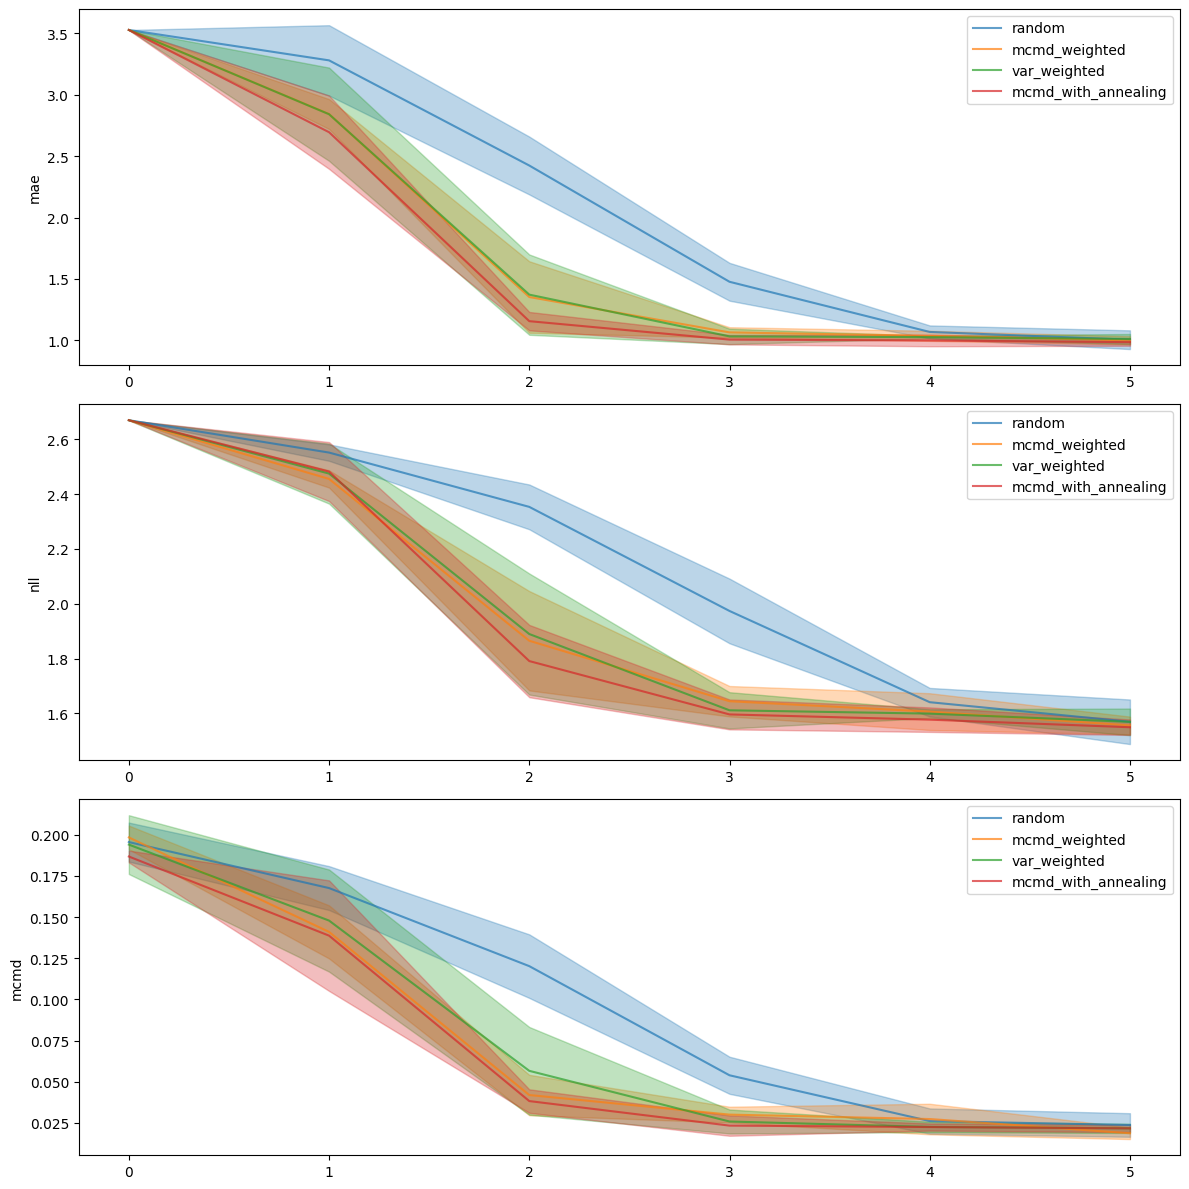

In [282]:
plot_all_metrics(["random", "mcmd_weighted", "var_weighted", "mcmd_with_annealing"])

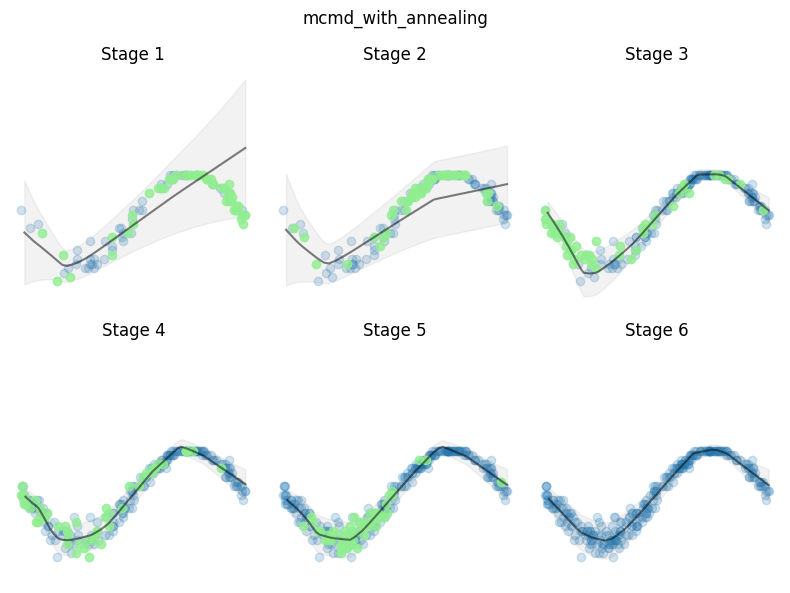

In [284]:
plot_data_selection("mcmd_with_annealing", 1)

10
10
10
10
10
10


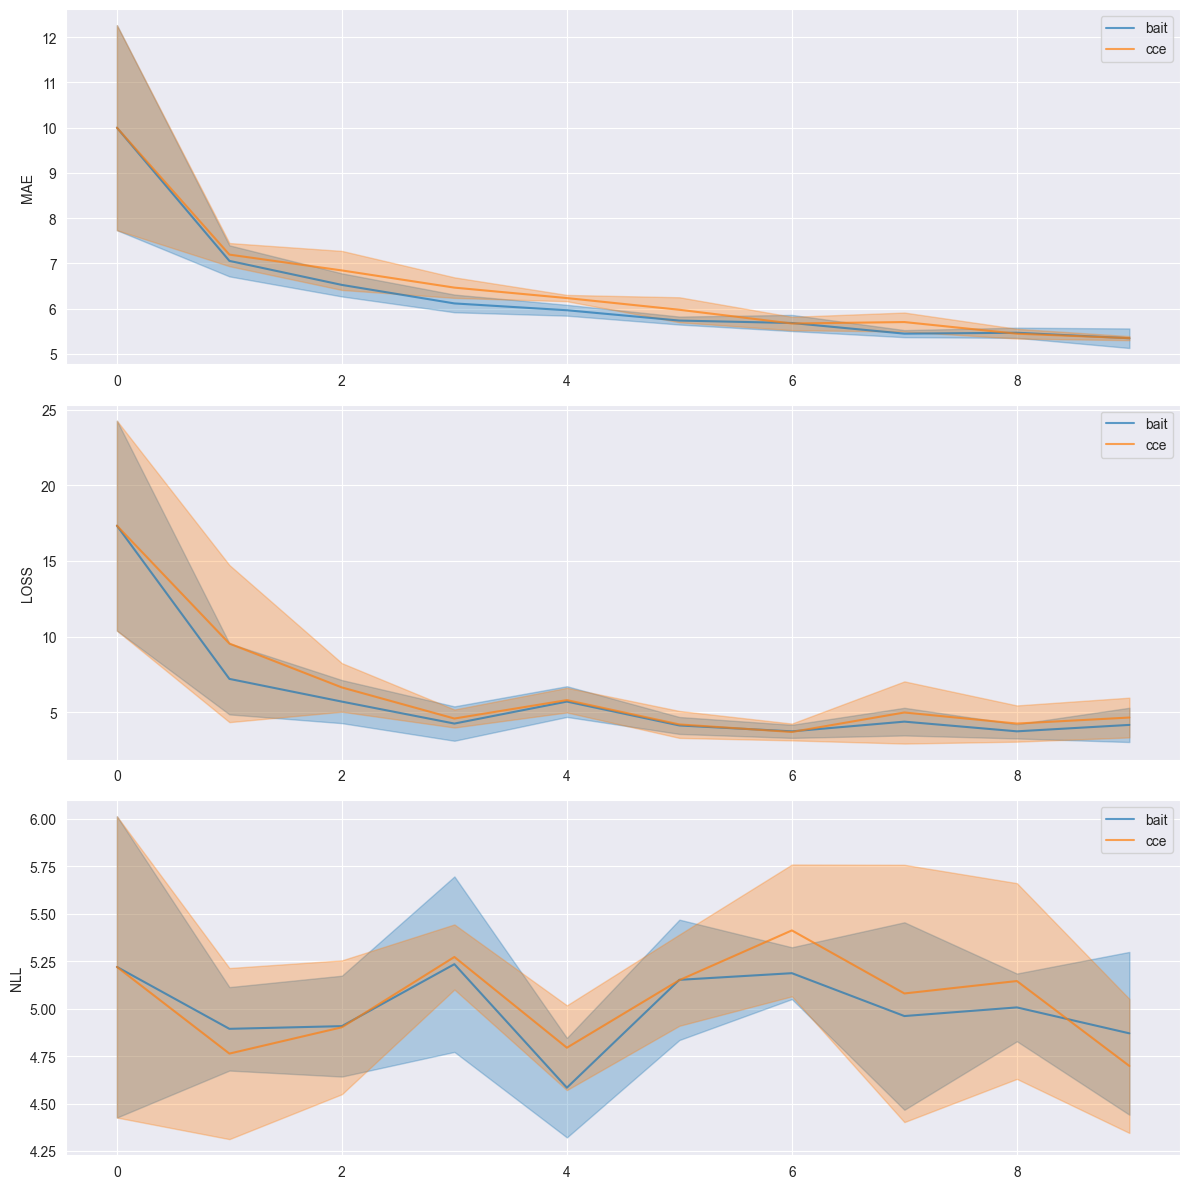

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import color_palette
import numpy as np


# strategies = ["random", "bait", "cce"]
strategies = ["bait", "cce"]

paths = [
    f"/Users/stocktonjenkins/Desktop/ace-icml/logs/{strategy}__aaf_gaussian/al_model_acc.csv"
    for strategy in strategies
]


fig, axs = plt.subplots(3, 1, figsize=(12, 12))
colors = color_palette(n_colors=len(paths))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("LOSS")
axs[2].set_ylabel("NLL")
for path, color, strategy in zip(paths, colors, strategies):
    results = pd.read_csv(path)
    for i, metric in enumerate(("MAE", "LOSS", "NLL")):
        metric_vals = []
        for al_iter, trials in results.groupby('A.L. Iteration'):
            metric_vals.append(trials[metric])
        metric_vals = np.stack(metric_vals, axis=0)
        mean_metric = metric_vals.mean(axis=1)
        std_metric = metric_vals.std(axis=1, ddof=1)
        axs[i].plot(mean_metric, color=color, alpha=0.7, label=strategy)
        axs[i].fill_between(np.arange(len(mean_metric)), mean_metric - std_metric, mean_metric + std_metric, alpha=0.3, color=color)

[ax.legend() for ax in axs.ravel()]
fig.tight_layout()
plt.show()